In [44]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges
import plotly.express as px
from sklearn import preprocessing
import pylab as pl
import matplotlib.ticker as tck

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Intron chain, TSS, TES triplet analysis

In [3]:
# get list of detected filtered isoforms
sg = swan.read('../swan/swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df, regions, counts = get_ic_tss_tes(sg,
                                         df,
                                         min_tpm=1, 
                                         gene_subset='polya',
                                         annot_slack=200,
                                         novel_slack=100)

# add triplets for samples
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
temp = compute_triplets(t_df,
                        df,
                        min_tpm=1,
                        groupby='sample')
counts = pd.concat([counts, temp])

# add tpm on the sample level to the table
df = pd.read_csv('../talon/human_talon_abundance.tsv', sep='\t')
gene_df,_ = get_tpm_table(df,
                         how='gene',
                         min_tpm=1, 
                         gene_subset='polya',
                         groupby='sample')
gene_df = gene_df.melt(ignore_index=False)
gene_df.rename({'value':'tpm'}, axis=1, inplace=True)
gene_df.reset_index(inplace=True)
gene_df.rename({'index': 'gid'}, axis=1, inplace=True)
counts = counts.merge(gene_df, how='left', left_on=['source', 'gid'], right_on=['biosample', 'gid'])

Read in graph from ../swan/swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [4]:
# save all observed triplets
temp = counts.loc[counts.source == 'obs']
temp.to_csv('obs_triplets.tsv', sep='\t', index=False)

In [5]:
c_dict, order = get_biosample_colors()

In [236]:
def zip_pts(df, c):
    return zip(df[c['a']], df[c['b']], df[c['c']])

def max_pts(df, c):
    return max(df[c['a']].max(), df[c['b']].max(), df[c['c']].max())

def density_dorito(counts,
                   c,
                   scale=20,
                   cmap='viridis',
                   log=False,
                   pad=0.15):
    """
    Plot the density of a dataset on a ternary plot
    From here: https://github.com/marcharper/python-ternary/issues/81
    
    Parameters:
        counts 
        c
        scale 
        cmap 
        
    Returns: 
        fig
        tax
        counts (pandas DataFrame): Counts, scaled by factor used
    """
    
#     nbins = scale+1
#     t = (np.array(counts[c['a']].tolist()),
#          np.array(counts[c['b']].tolist()),
#          np.array(counts[c['c']].tolist()))

#     H, b = np.histogramdd(t,
#                           bins=(nbins, nbins, nbins),
#                           range=((0, 1), (0, 1), (0, 1)))
#     # H = H / np.sum(H)

#     # 3D smoothing and interpolation
#     kde = gaussian_filter(H, sigma=scale/15)
#     interp_dict = dict()
#     binx = np.linspace(0, 1, nbins)
#     for i, x in enumerate(binx):
#         for j, y in enumerate(binx):
#             for k, z in enumerate(binx):
#                 # print(i,j,k)
#                 interp_dict[(i, j, k)] = kde[i, j, k]
#                 # interp_dict[(i, j, k)] = H[i, j, k]
    
#     df = pd.DataFrame.from_dict(interp_dict, orient='index')
#     # print(df.loc[df[0] > 0])

    from collections import defaultdict
    hm_dict = defaultdict(int)
    for i in range(0, scale+1):
        for j in range(0, scale+1):
            for k in range(0, scale+1):
                if i+j+k == scale:
                    # print(i,j,k)
                    # i = 1
                    # j = 1
                    # k = 1
                    temp = counts.copy(deep=True)
                    if i != scale:
                        temp = temp.loc[(temp.tss_ratio*scale>=i)&(temp.tss_ratio*scale<i+1)]
                        # print(temp)
                    else:
                        temp = temp.loc[(temp.tss_ratio*scale>=i)&(temp.tss_ratio*scale<=i+1)]
                    if j != scale:
                        temp = temp.loc[(temp.top_ratio*scale>=j)&(temp.top_ratio*scale<j+1)]
                        # print(temp)
                    else:
                        temp = temp.loc[(temp.top_ratio*scale>=j)&(temp.top_ratio*scale<=j+1)]
                    # print(i)
                    # print(j)
                    # print(temp.head())
                    n = len(temp.index)
                    # print(n)
                    hm_dict[i,j] += n
            
    # log values if necessary
    if log:
        for key, item in hm_dict.items():
            hm_dict[key] = np.log2(item+1)
    
    # double checking stuff
    df = pd.DataFrame.from_dict(hm_dict, orient='index')
    df['i'] = [b[0] for b in df.index.tolist()]
    df['j'] = [b[1] for b in df.index.tolist()]
    # df['k'] = [b[2] for b in df.index.tolist()]
    df.rename({0:'val'}, axis=1, inplace=True)
    # print(df.loc[df.val >= 14])
    
    
        
    figure, tax = ternary.figure(scale=scale, permutation='210')
    tax.heatmap(hm_dict, colorbar=False, style='t')
    # tax.heatmap(interp_dict, colorbar=False)
    
    # scale according to chosen resolution
    for key in c.keys():
        counts[c[key]] = counts[c[key]]*scale
        
    # colorbar - hacked together by broken ternary code 
    ax = tax.get_axes()
    flat = []
    for key, item in hm_dict.items():
        flat.append(item)
    min_val = min(flat)
    max_val = max(flat)
    # print(min_val)
    # print(max_val)
    norm = plt.Normalize(vmin=min_val, vmax=max_val)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    
    def exp_format(x,pos):
            x = int(x)
            return r'$2^{{{}}}$'.format(x)
    
    if not log:
        cb = plt.colorbar(sm, ax=ax, pad=pad)
    else:
        cb = plt.colorbar(sm, ax=ax, pad=pad, 
                          format=tck.FuncFormatter(exp_format))
    
    for t in cb.ax.get_yticklabels():
        t.set_fontsize(16)
    if not log:
        cb.ax.set_yticklabels([])
        cb.ax.set_yticks([])

    cb.set_label('Density', size=16)
    
    return figure, tax, counts

def jitter_dorito(counts, c, scale):
    """
    Parameters:
        counts 
        c
        scale
    
    Returns
        counts
        c
    """
    
    # figure out how much to jitter by 
    sigma = (1/250)*scale
    for d in c.keys():
        d_jitter = '{}_jitter'.format(d)
        counts[d_jitter] = counts[c[d]].apply(lambda x: np.random.normal(x, sigma))
        c[d] = d_jitter
    
    return counts, c
    
def scatter_dorito(counts,
                   c, 
                   hue,
                   size,
                   log_size,
                   cmap, 
                   mmap,
                   alpha,
                   density,
                   figure, 
                   tax):
    """
    Parameters 
        counts (pandas DataFrame): subset the thing
        c (dict of str): Dictionary of column names to plot as a, b, c 
            indexed by 'a', 'b', 'c'
    """
    
    def scale_col(points, counts, col, log=False, how='color'):
            if log:
                log_col = '{}_log'.format(col)
                counts[log_col] = np.log2(counts[col])
                col = log_col
            vals = counts[[col]]
            max_val = vals[col].max()
            min_val = vals[col].min()
            min_max_scaler = preprocessing.MinMaxScaler(feature_range=(10, 300))
            vals = min_max_scaler.fit_transform(vals)
            max_scaled = max(vals)
            min_scaled = min(vals)
            
            # replace nans w/ 100
            vals = [100 if np.isnan(v) else v for v in vals]
            
            return vals, min_val, max_val, min_scaled, max_scaled
        
    # defaults
    points = [(x[0], x[1], x[2]) for x in zip_pts(counts, c)]
    labels = ['' for i in range(len(points))]
    hue_type = None
    figsize = (10,10)
    colors = '#e78424'
    if len(points) < 50:
        sizes = [100 for i in range(len(points))]
    else:
        sizes =  [20 for i in range(len(points))]
    markers = 'o'
    vmin = 0
    vmax = 1
    plotted = False
        
    # get color
    if hue:
        
        # categorical
        if counts[hue].dtype.name == 'object':
            hue_type = 'cat'
            colors = counts[hue].map(cmap).tolist()
            labels = counts[hue].tolist()

        # continuous
        else:
            hue_type = 'cont'
            colors, abs_min, abs_max, vmin, vmax = scale_col(points, counts, hue)
    
    # get sizes
    if size:
        sizes,_,_,_,_ = scale_col(points, counts, size, log_size)
        
    # marker style
    if mmap:
        markers = [mmap[val] if val in mmap.keys() else 'o' for val in counts[hue].unique()]
        
    # figure size handling
    if hue_type == 'cat' and density: figsize = (13,10)
    elif hue_type == 'cat' and not density: figsize = (10,10)
    elif hue_type == 'cont' and density: figsize = (16,10)
    elif hue_type == 'cont' and not density: figsize = (13,10)
    elif density: figsize = (13,10)
    figure.set_size_inches(figsize[0], figsize[1])
    
    # actual scatter call
    if hue_type == 'cat':
        for point, color, size, label, marker in zip(points, colors, sizes, labels, markers):
            tax.scatter([point], vmin=vmin, vmax=vmax,
                    s=size, c=color, cmap=cmap,
                    marker=marker,label=label,
                    alpha=alpha, zorder=3)
    else:   
        tax.scatter(points, vmin=vmin, vmax=vmax,
                    s=sizes, c=colors, cmap=cmap, marker=markers,
                    alpha=alpha, zorder=3)
    
    # legend handling
    if hue_type == 'cat':
        if density: x = 1.6
        else: x = 1.4
        tax.legend(bbox_to_anchor=(x, 1.05),
                   loc='upper right', prop={'size': 14})
        
        # fix marker size
        ax = tax.get_axes()
        lgnd = ax.get_legend()
        for handle in lgnd.legendHandles:
            handle._sizes = [100]
    
    # colorbar handling
    if hue_type == 'cont':
        ax = tax.get_axes()
        norm = plt.Normalize(vmin=abs_min, vmax=abs_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        cb = plt.colorbar(sm, ax=ax, pad=0.1)
        for t in cb.ax.get_yticklabels():
             t.set_fontsize(16)
        if hue == 'tss' or hue == 'tes':
            cb.set_label('# {}s'.format(hue.upper()), size=16)
        elif hue == 'intron_chain':
            cb.set_label('# {}s'.format(hue), size=16)
        
    return figure, tax

In [237]:
def plot_dorito(counts,
                top='splicing_ratio',
                subset=None,
                gene=None,
                hue=None,
                cmap='magma',
                mmap=None,
                density=False,
                density_scale=1,
                density_cmap='viridis',
                log_density=False,
                scatter=True,
                size=None,
                log_size=False,
                jitter=False,
                alpha=1,
                scale=True,
                title=None,
                opref='figures/'):
    """
    Plot a dorito from counts with the given subset in a given 
    color
    
    Parameters:
        counts (pandas DataFrame): DF of the counts per gene 
            of ic, tss, tes from get_ic_tss_tes or
            compute_triplets (or both!!!)
        top (str): Column name to plot as apex of dorito.
            Choose from 'ic' or 'splicing_ratio'
        subset (dict of lists): List mapping counts column names
            to values in said columns to include in the data
        hue (str): Column from counts to color by
        cmap (str or dict of str): Either a dictionary mapping
            categorical column values from hue or a valid 
            matplotlib continuous named color palette
        mmap (str or dict of str): Dictionary mapping categorical
            column values from hue to marker styles
        scale (bool): Whether to scale values b/w 1 and 0. 
        alpha (float): Alpha value of points
        title (str): Title to give plot
        opref (str): Output file prefix to save fig
    """
    
    #### subset dataset and transform numbers as needed ####
    temp = counts.copy(deep=True)

    # if we have a gene name, limit to those entries
    if gene:
        temp = temp.loc[temp.gname == gene]

    # if we have a list of allowed sources, limit to those entries
    if subset:
        for col, val in subset.items():
            if type(val) != list:
                val = [val]
            temp = temp.loc[temp[col].isin(val)]
            
    # scale and assign which columns to use 
    c = dict()
    if scale:
        if top == 'splicing_ratio':
            temp['total'] = temp.tss+temp.tes+temp.splicing_ratio
        elif top == 'intron_chain':
            temp['total'] = temp.tss+temp.tes+temp.intron_chain
        temp['tss_ratio'] = temp.tss/temp.total
        temp['tes_ratio'] = temp.tes/temp.total
        temp['top_ratio'] = temp[top]/temp.total

        c['a'] = 'tss_ratio'
        c['b'] = 'top_ratio'
        c['c'] = 'tes_ratio'
    else:
        c['a'] = 'tss'
        c['b'] = top
        c['c'] = 'tes'
    
    if scale == True:
        scale = 1
        mult = 0.2
    else: 
        scale = max_pts(temp, c)
        
    # density
    if density:
        if hue:
            if counts[hue].dtype.name == 'object':
                pad = 0.1
            else:
                pad = 0.0
        else:
            pad = 0.1
        figure, tax, temp = density_dorito(temp, c, 
                                 density_scale, 
                                 density_cmap, 
                                 log_density,
                                 pad=pad)
        scale = density_scale
        figure.set_size_inches(13,10)
        
    # if we're jittering, adjust the points for each thing
    if jitter:
        temp, c = jitter_dorito(temp, c, density_scale) 

    # figure layout parameters
    fontsize = 18
    offset = 0.1
    mult = scale/5

    # if we don't already have a fig and axis from density,
    # make one
    if not density:
        figure, tax = ternary.figure(scale=scale, permutation='210')
        figure.set_facecolor('white')

    # plot gridlines below the scatterplot
    tax.gridlines(linewidth=3, multiple=mult,
                  color='white', zorder=1, linestyle=None)
    
    # scatter
    if scatter:
        figure, tax = scatter_dorito(temp, c, hue,
                                    size, log_size,
                                    cmap, mmap, alpha, density, 
                                    figure, tax)

    # title handler
    if not title:
        if gene:
            title = '$\it{}$\n\n'.format(gene)
        else:
            title = ''
    else:
        if gene:
            title = '{} $\it{}$\n\n'.format(title, gene)
        else:
            title = '{}\n\n'.format(title)

    tax.set_title(title, fontsize=20)
    tax.boundary(linewidth=2, c='#e5ecf6')
    labels = ['{:.1f}'.format(n) for n in np.arange(0, 1.2, .2)]
    tax.ticks(ticks=labels,
              axis='lbr', linewidth=1, multiple=mult,
              tick_formats="%.1f", offset=0.014,
              fontsize=14)
    # tax.ticks(axis='lbr', linewidth=1, multiple=mult,
    #           tick_formats="%.1f", offset=0.014,
    #           fontsize=14)
    
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.set_background_color('#e5ecf6')

    if top == 'splicing_ratio':
        top_label = 'Splicing ratio $\\beta$'
    elif top == 'intron_chain':
        top_label = '# intron chains $\\delta$'
    tax.left_corner_label('# TSSs $\\alpha$', fontsize=fontsize)
    tax.top_corner_label(top_label, fontsize=fontsize)
    tax.right_corner_label('# TESs $\\gamma$', fontsize=fontsize)
    
    figure.set_facecolor('white')
        
    # tax.show()
    
    # save figure
    fname = opref
    if gene:
        fname += '_{}'.format(gene)
    if density:
        fname += '_density'
    if scatter:
        fname += '_scatter'
    if hue:
        fname += '_{}'.format(hue)
    fname += '.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight')               
    
    return temp

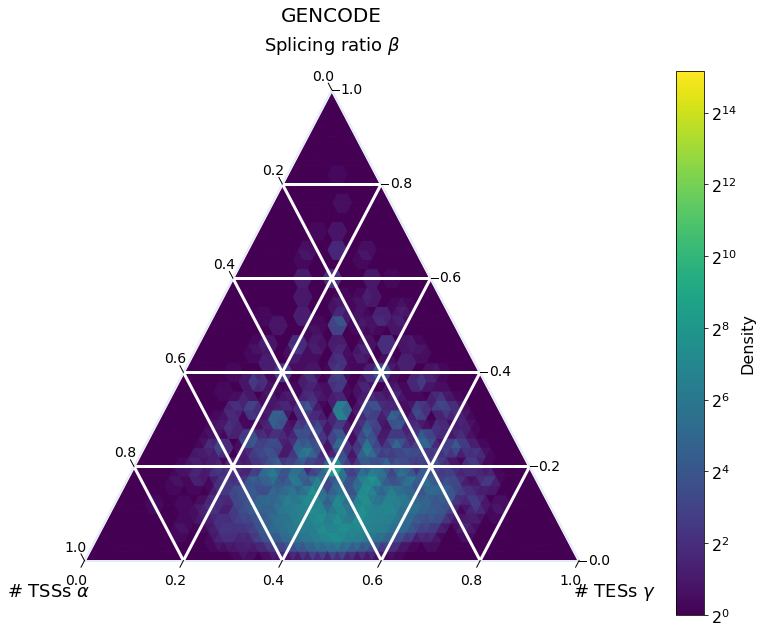

In [238]:
# gencode
temp = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'GENCODE'},
            density=True,
            density_scale=50,
            log_density=True,
            scatter=False,
            title='GENCODE',
            opref='figures/human')

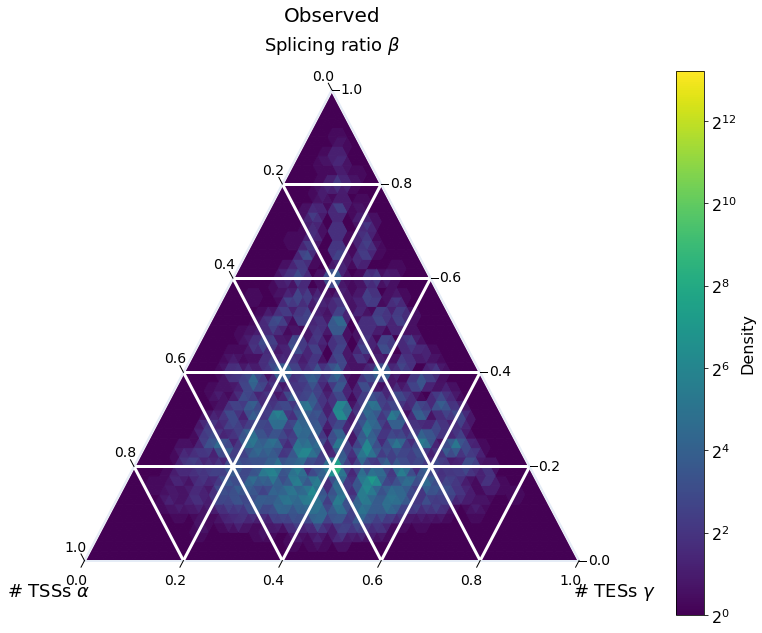

In [239]:
# observed
temp = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'obs'},
            density=True,
            density_scale=50,
            log_density=True,
            scatter=False,
            title='Observed',
            opref='figures/human')

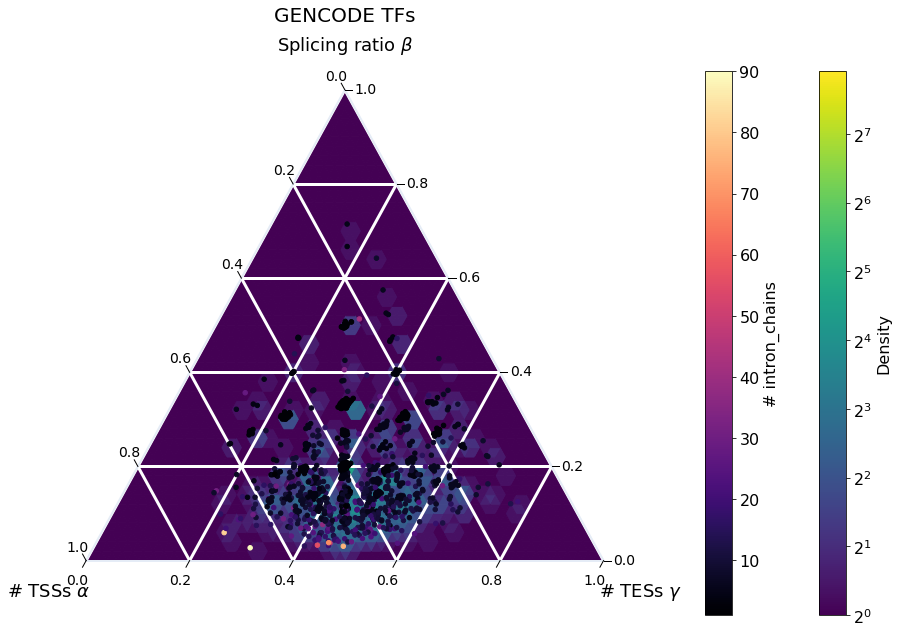

In [241]:
# all tfs in gencode
temp = plot_dorito(counts,
                top='splicing_ratio',
                hue='intron_chain',
                subset={'source': 'GENCODE', 'tf': True},
                jitter=True,
                density=True,
                density_scale=50,
                log_density=True,
                title='GENCODE TFs',
                opref='figures/human')

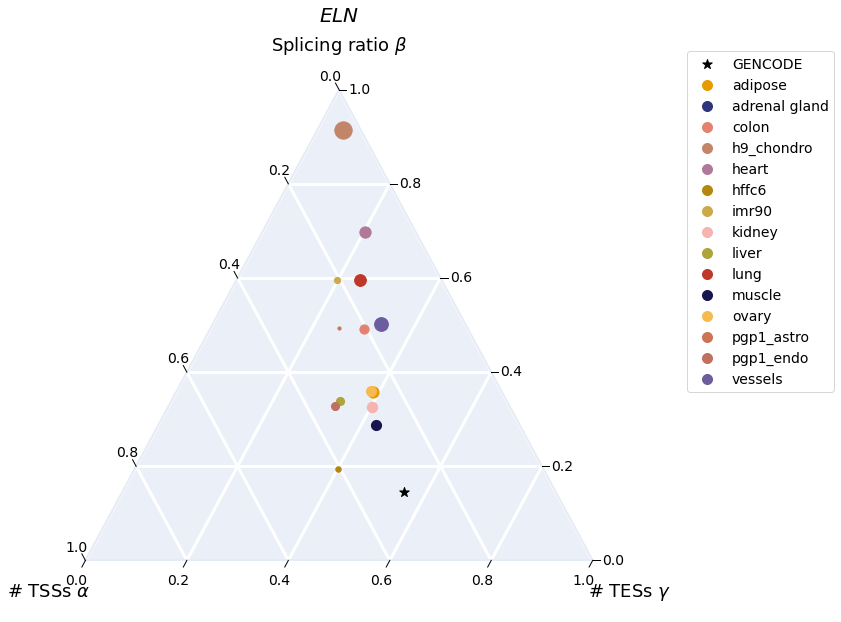

In [242]:
# ELN
gc_c_dict = c_dict
gc_c_dict['GENCODE'] = 'k'
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='ELN',
            hue='source',
            size='tpm', 
            log_size=True,
            cmap=gc_c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))}, 
            opref='figures/human')

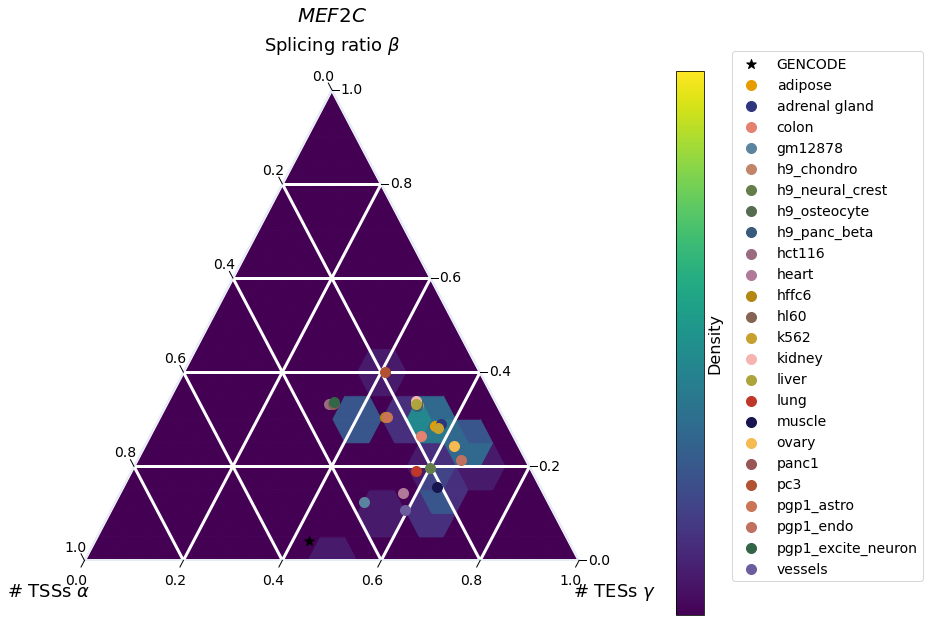

In [243]:
# MEF2C
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=gc_c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))}, 
            opref='figures/human')

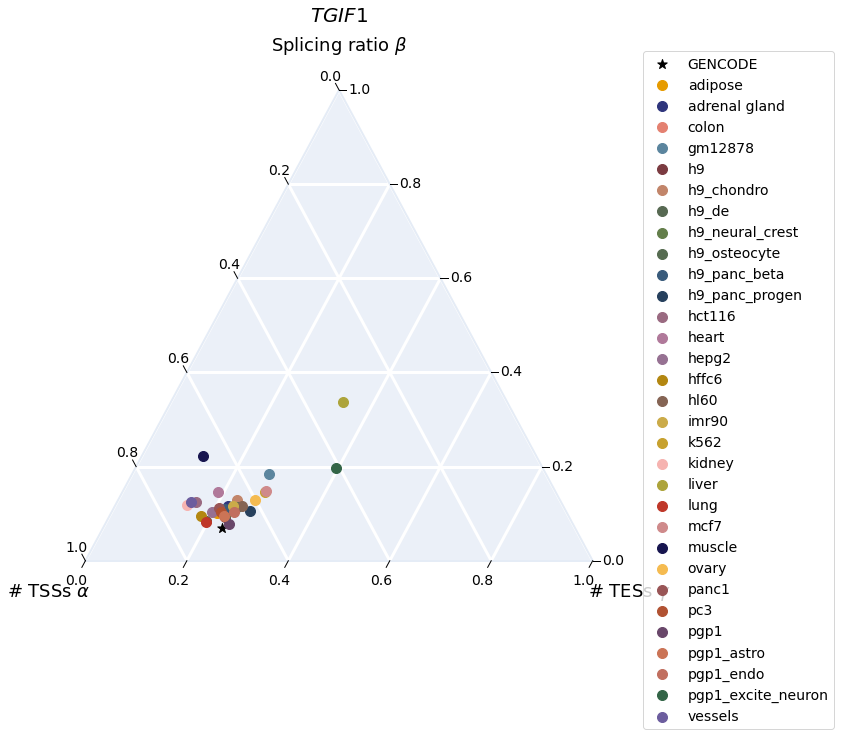

In [244]:
# TGIF1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TGIF1',
            hue='source',
            cmap=gc_c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))}, 
            opref='figures/human')

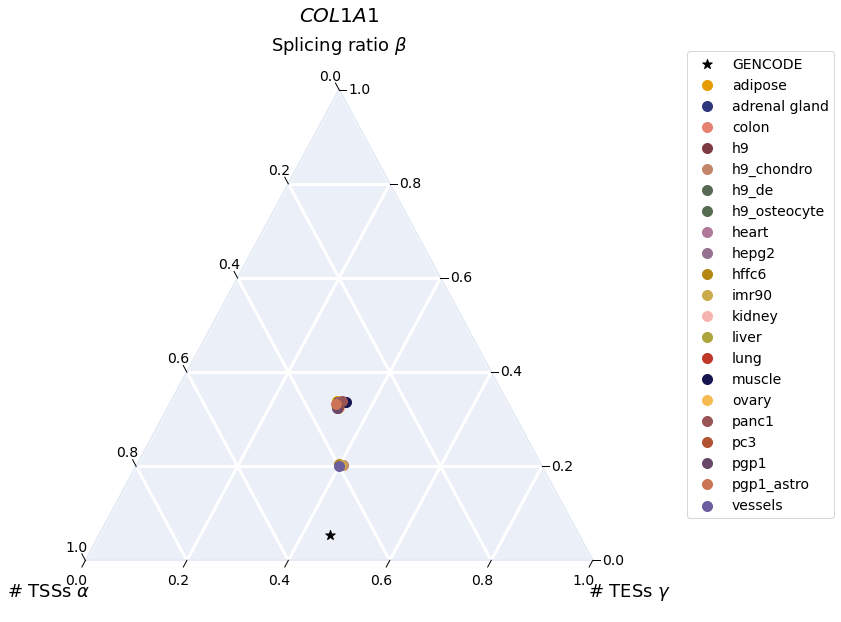

In [245]:
# COL1A1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=gc_c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))}, 
            opref='figures/human')

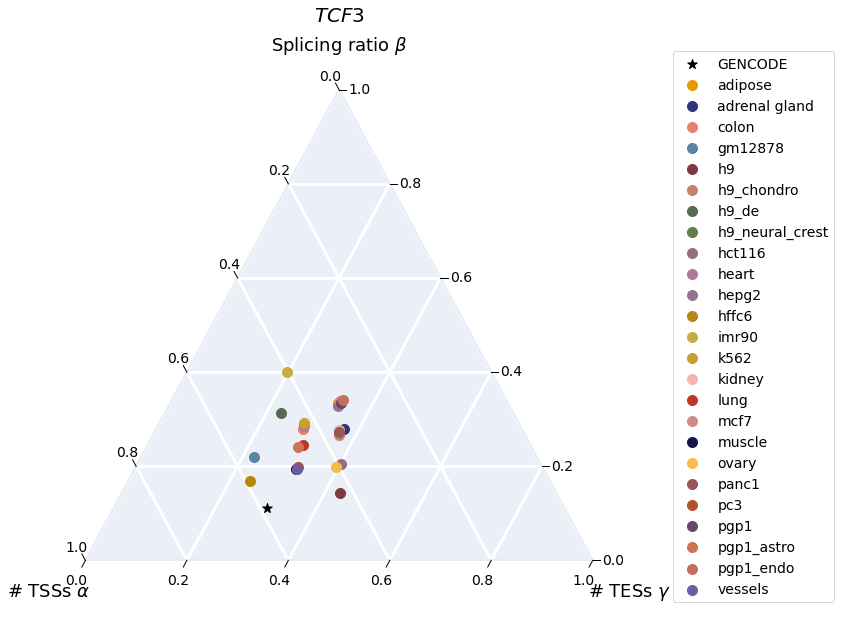

In [246]:
# TCF3
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=gc_c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

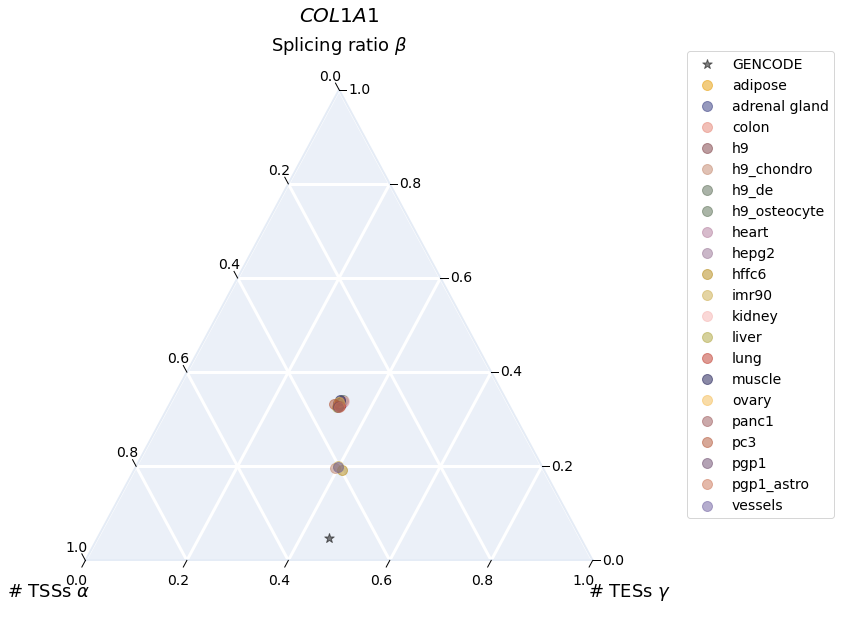

In [247]:
# COL1A1
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            alpha=0.5,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

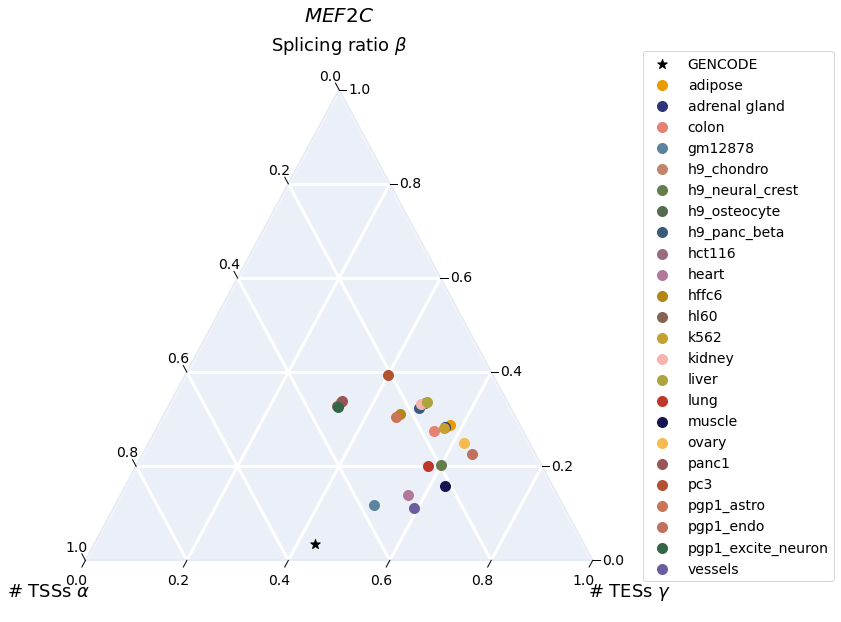

In [251]:
# MEF2C
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

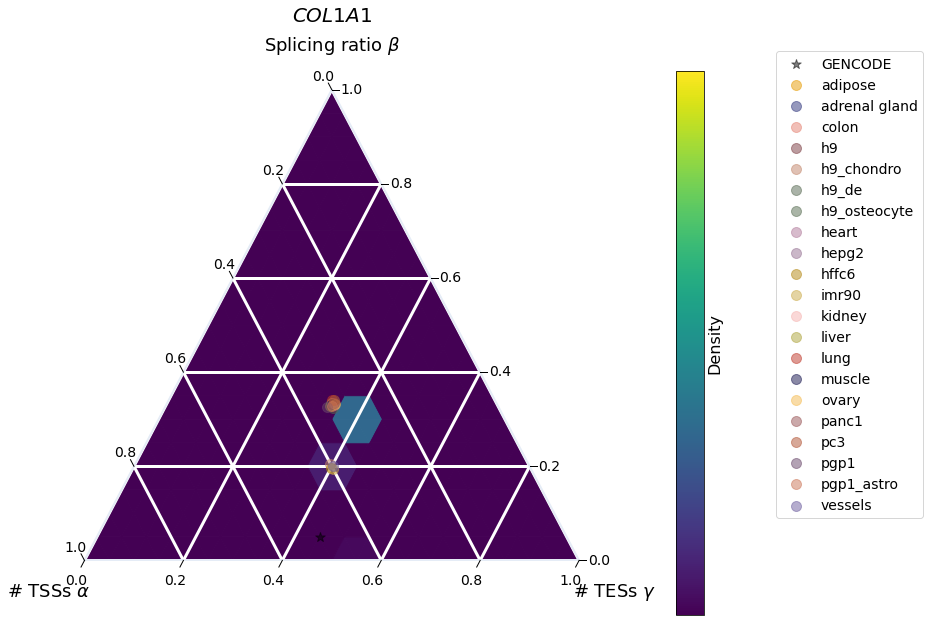

In [252]:
# COL1A1
gc_c_dict = c_dict
gc_c_dict['GENCODE'] = 'k'
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            density=True,
            density_scale=20,
            jitter=True,
            alpha=0.5,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

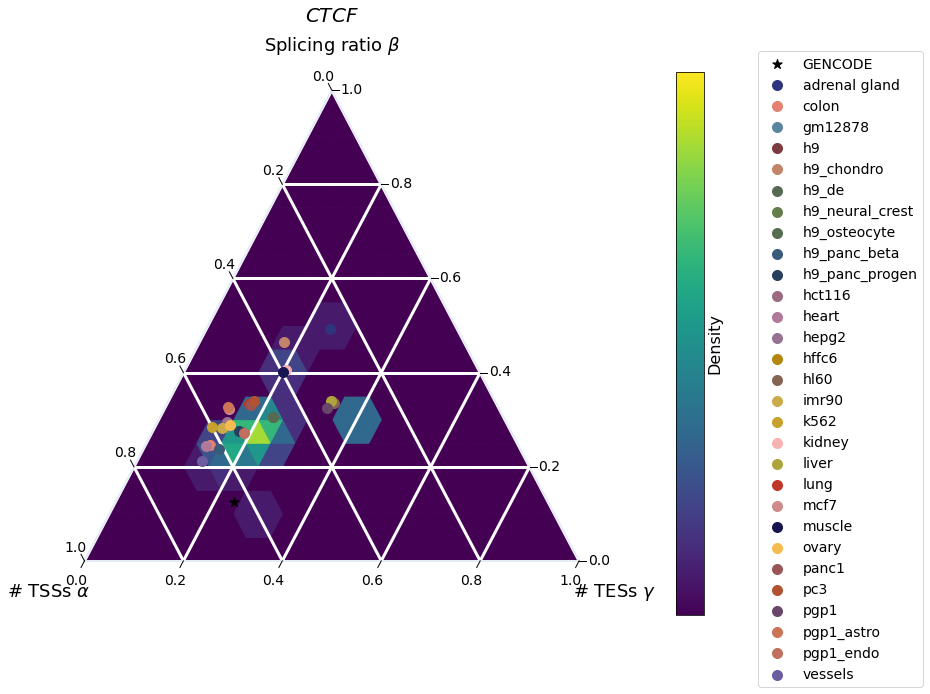

In [253]:
# CTCF
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='CTCF',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            density=True,
            density_scale=20,
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

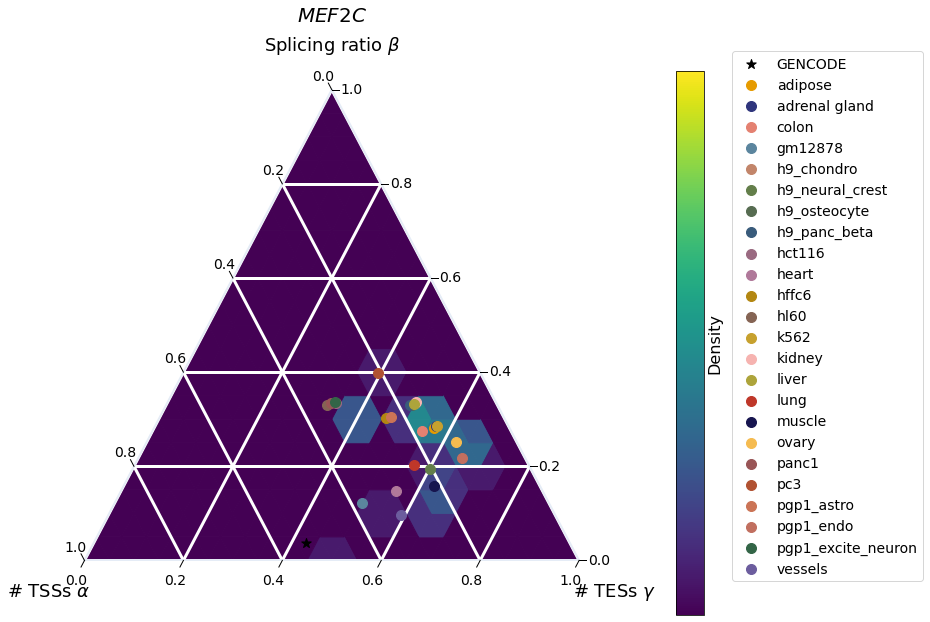

In [255]:
# MEF2C
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

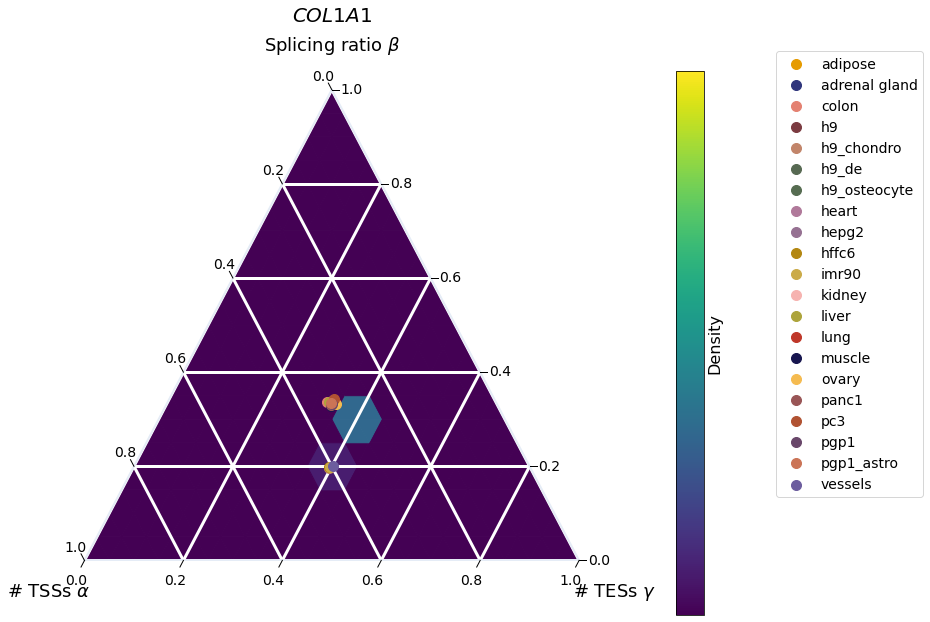

In [256]:
# COL1A1
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['GENCODE', 'all', 'obs']))})

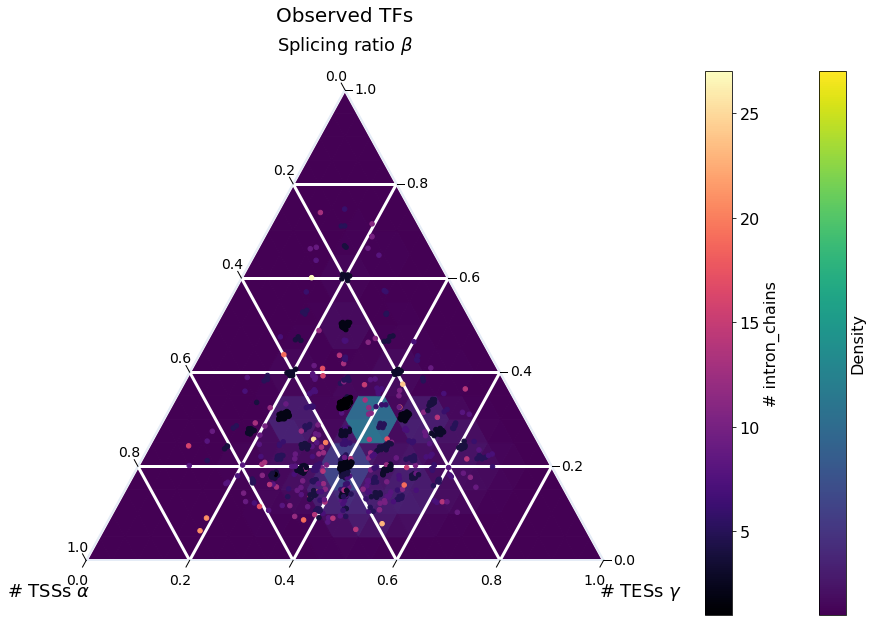

In [257]:
# all tfs in observed example
temp = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            density=True, 
            density_scale=20,
            jitter=True,
            subset={'source': 'obs', 'tf': True},
            title='Observed TFs')

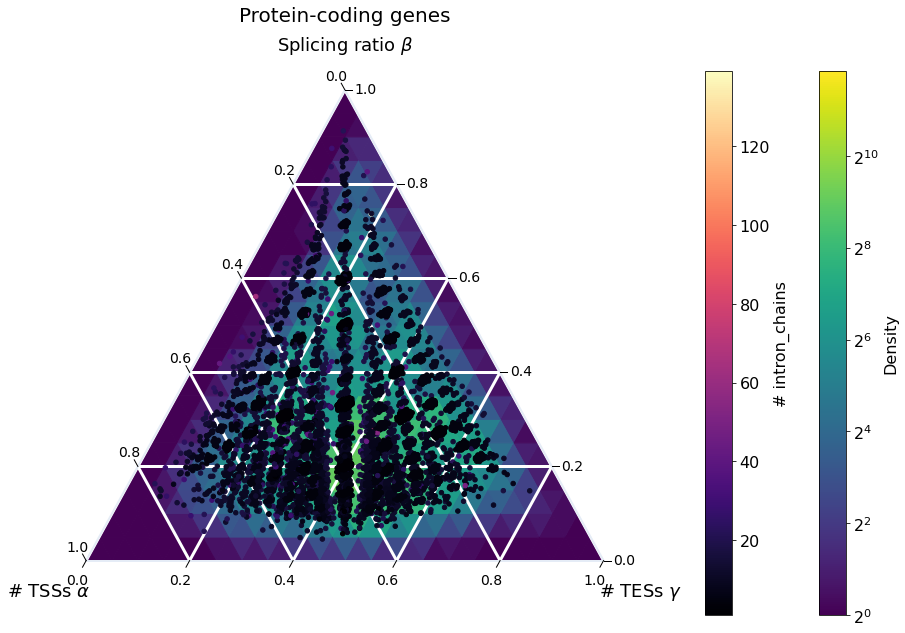

In [259]:
# all protein-coding genes in gencode example
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            density=True,
            density_scale=20,
            log_density=True,
            jitter=True,
            subset={'biotype': 'protein_coding', 'source': 'obs'},
            title='Protein-coding genes')

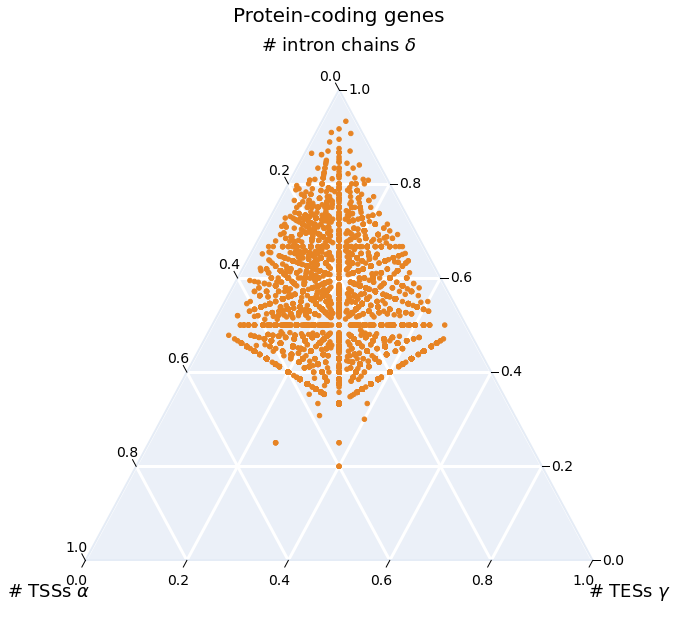

In [260]:
# all protein-coding genes in gencode example
_ = plot_dorito(counts,
            top='intron_chain',
            subset={'biotype': 'protein_coding', 'source': 'obs'},
            title='Protein-coding genes')

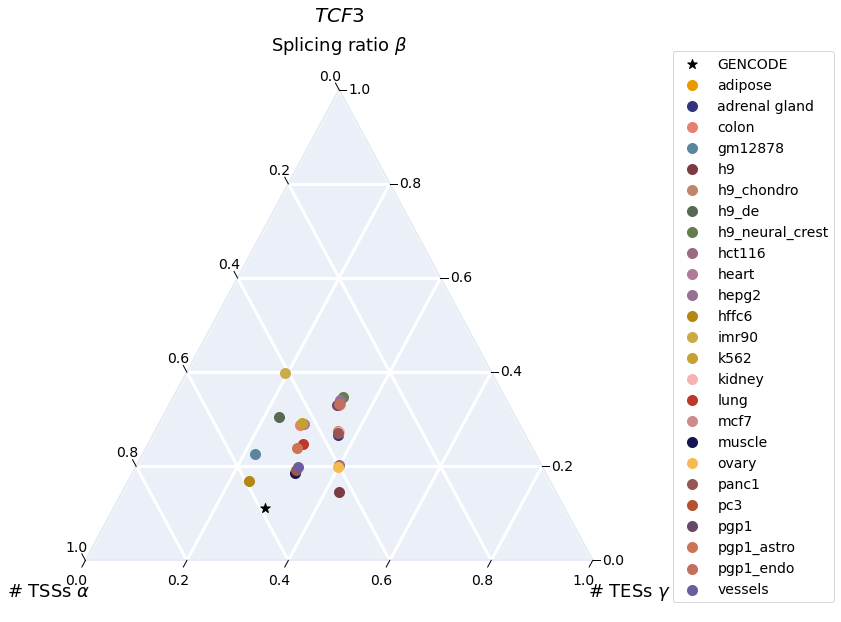

In [262]:
# gene example
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            jitter=True,
            mmap={'GENCODE': '*'},
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

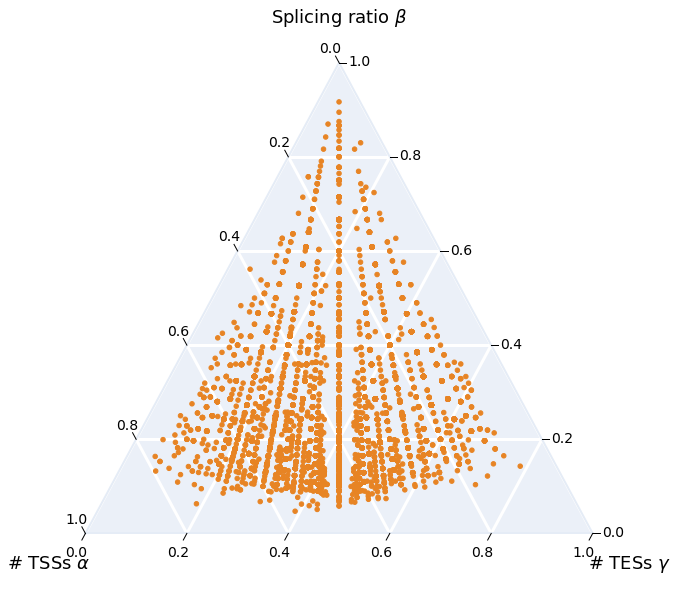

In [263]:
# obs example
_ = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'obs'})

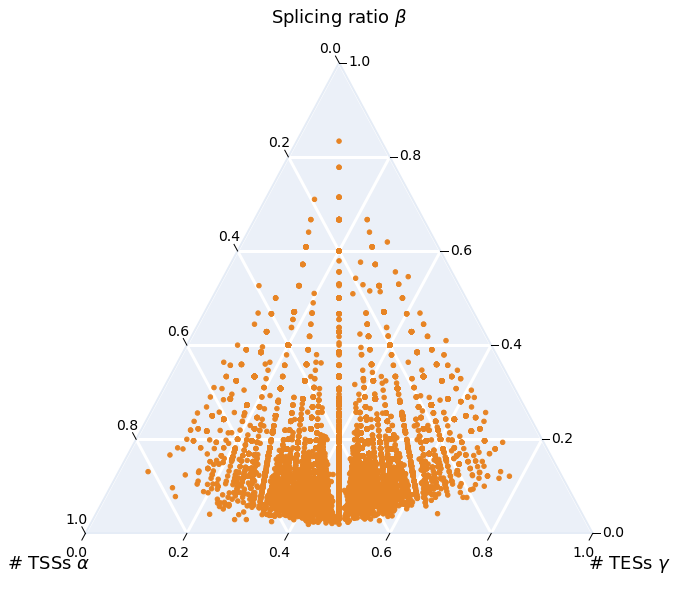

In [264]:
# gencode example
_ = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'GENCODE'})

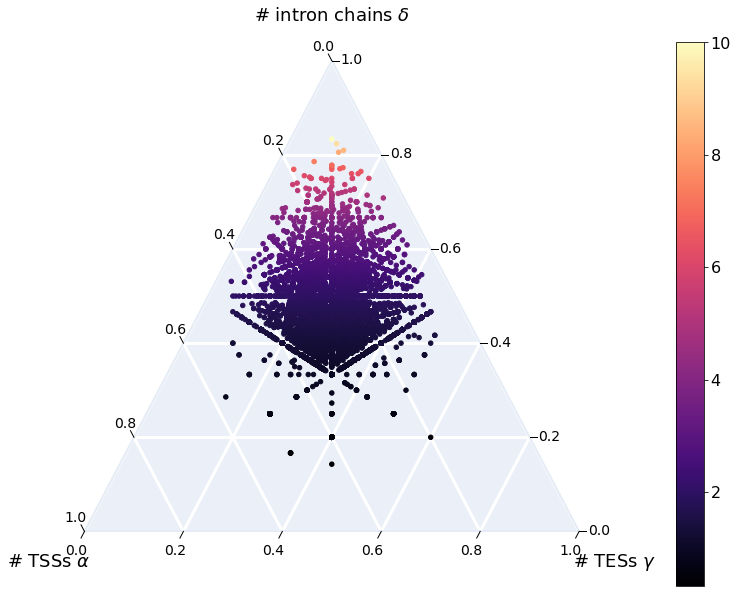

In [265]:
# gencode example - color by splicing ratio
_ = plot_dorito(counts,
            top='intron_chain',
            hue='splicing_ratio',
            subset={'source': 'GENCODE'})

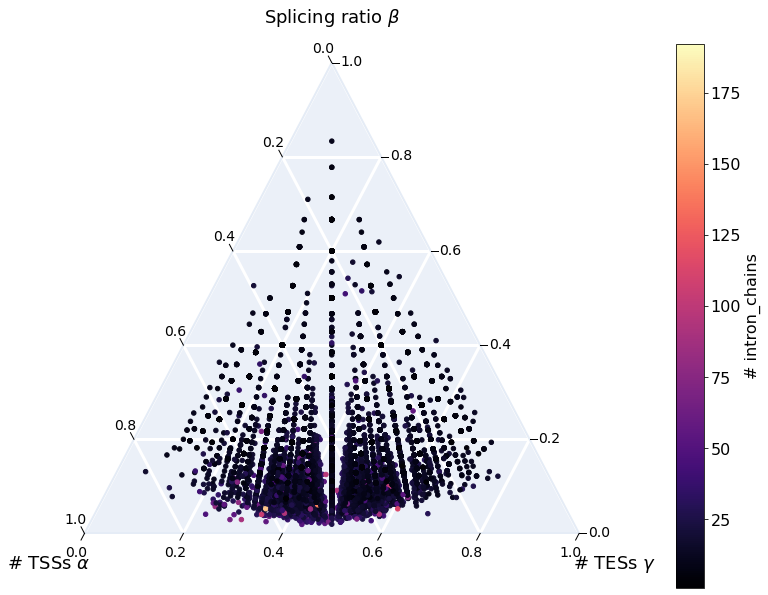

In [266]:
# gencode example - color by splicing ratio
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source': 'GENCODE'})

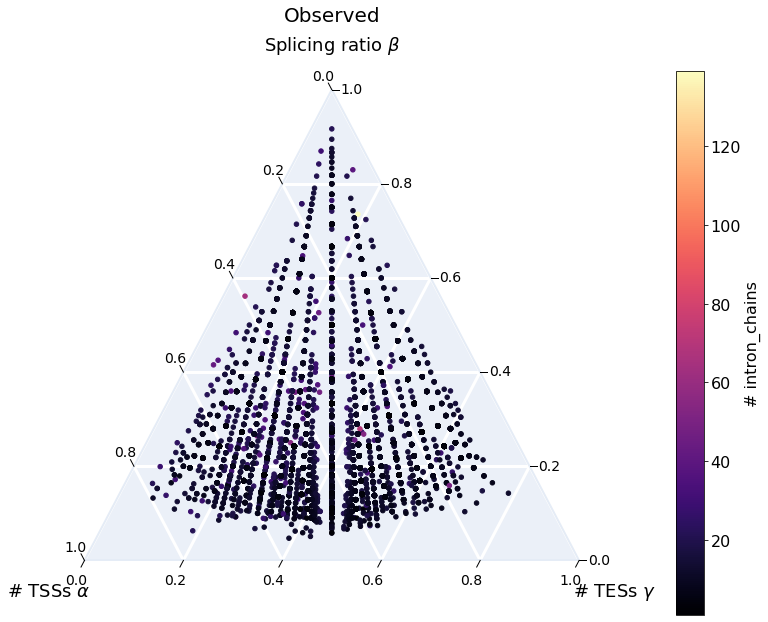

In [268]:
# observed example - color by n ic
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source':'obs'},
            title='Observed')

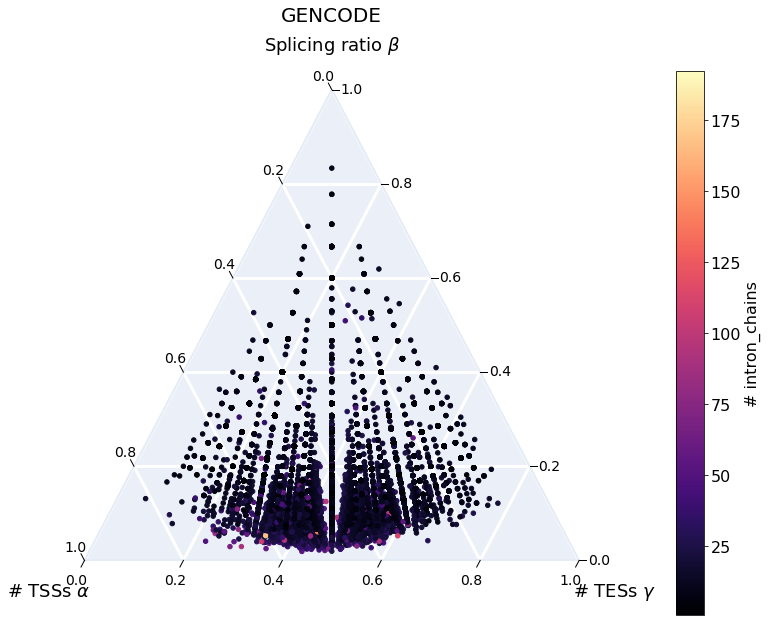

In [270]:
# gencode example - color by n ic
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source':'GENCODE'},
            title='GENCODE')

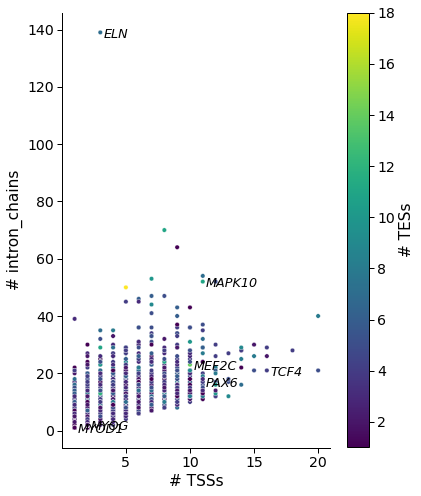

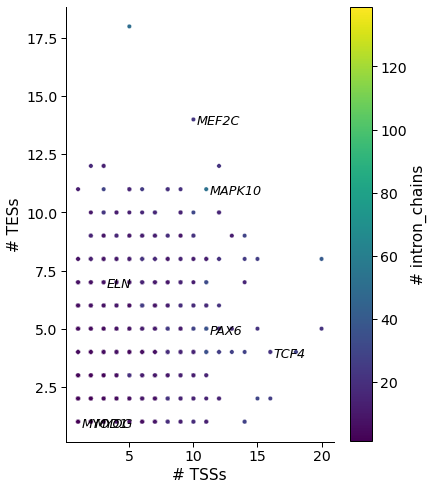

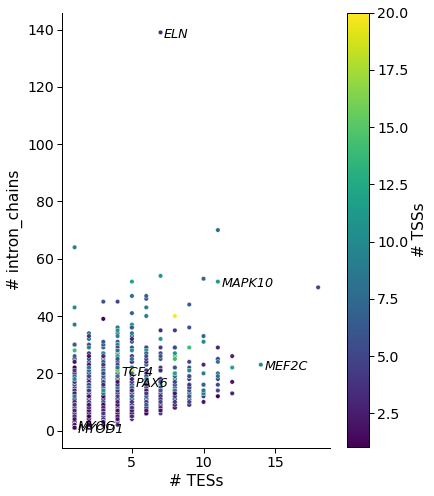

In [271]:
genes = ['PAX6', 'TCF4', 'MAPK10', 'ELN', 'MEF2C', 'MYOD1', 'MYOG']
plot_n_ic_tss_tes(counts.loc[counts.source=='obs'], 
                  label_genes=genes,
                  kind='obs',
                  opref='figures/human')

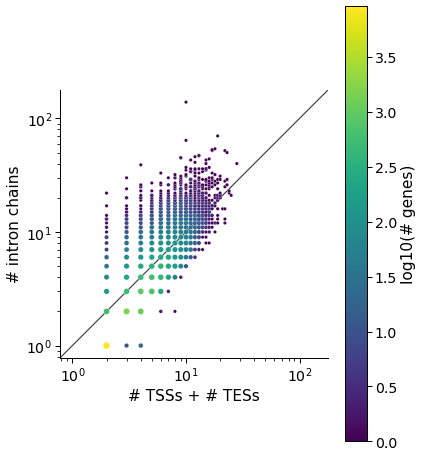

In [272]:
plot_genes_n_ic_ends(counts.loc[counts.source=='obs'], 
                     kind='obs', 
                     opref='figures/human')